In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scrnatools as rna
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import math
import phagepy
from phagepy import analysis

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [74]:
def average_tech_reps(adata, sample_key, layer="X"):
    counts = rna.tl.get_expression_matrix(adata, gene_data=layer)
    counts[sample_key] = adata.obs[sample_key]
    counts = counts.groupby(sample_key).mean()
    avg_adata = sc.AnnData(counts)
    obs = pd.DataFrame(adata.obs.copy())
    obs.index = obs[sample_key]
    obs = obs.drop_duplicates(subset=sample_key)
    avg_adata.obs = avg_adata.obs.join(obs)
    return avg_adata

def calculate_FC(adata, control_key, control_values, layer="X", layer_added="FC"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if np.any(np.sum(control_data,axis=0)==0):
        raise ValueError('Zero expression peptides. Pseudocount +1 before running.')
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = all_data/control_data.mean()
    
def calculate_Z(adata, control_key, control_values, layer="X", layer_added="Z_score"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if sum(control_data.sum(axis=0) == 0) > 0:
        print("Warning: some peptides have 0 variance in the control samples, some Z scores will be inf/NA")
    mean = control_data.mean(axis=0)
    std = control_data.std(axis=0) # Uses unbiased estimator of population variance by default (div by n-1 instead of n)
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = (all_data-mean)/std
    
def get_peptide_stats(adata, FC_layer, Z_layer, FC_thresh, Z_thresh, obs_grouping_key, key_added="hits", stats_layer=None):
    FC_thresholded = rna.tl.get_expression_matrix(adata, gene_data=FC_layer) > FC_thresh
    Z_thresholded = rna.tl.get_expression_matrix(adata, gene_data=Z_layer) > Z_thresh
    hits = FC_thresholded & Z_thresholded
    
    hits[obs_grouping_key] = adata.obs[obs_grouping_key]
    hits = hits.groupby(obs_grouping_key).sum().T
    hits["gene"] = adata.var.gene
    hits["sequence"] = adata.var.sequence
    
    if stats_layer is None:
        stats_layer = FC_layer
    LFC_background = rna.tl.get_expression_matrix(adata, gene_data=stats_layer)
    LFC_background[obs_grouping_key] = adata.obs[obs_grouping_key]
    group_min = LFC_background.groupby(obs_grouping_key).min().T
    hits = hits.join(group_min, rsuffix='_min')
    group_max = LFC_background.groupby(obs_grouping_key).max().T
    hits = hits.join(group_max, rsuffix='_max')
    group_med = LFC_background.groupby(obs_grouping_key).median().T
    hits = hits.join(group_med, rsuffix='_median')
    group_mean = LFC_background.groupby(obs_grouping_key).mean().T
    hits = hits.join(group_mean, rsuffix='_mean')
    
    adata.varm[key_added] = hits
    

def corr_plot(adata, layer="X", labels=None, cbar_args = [1, 0.25, 0.01, 0.5], *args, **kwargs):
    data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    gene_corrs = pd.DataFrame(np.corrcoef(data), index=data.index, columns=data.index)
    if labels is not None:
        label_names = adata.obs.loc[gene_corrs.index, labels]
        gene_corrs.index = label_names
        gene_corrs.columns = label_names
    cg = sns.clustermap(
        gene_corrs,
        cmap="coolwarm",
        yticklabels=True,
        xticklabels=True,
        *args, **kwargs
    )

    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_cbar.set_position(cbar_args)
    plt.show()
    
def plot_FC_sum(adata, FC_layer, obs_group_key, obs_group_values=None, *args, **kwargs):
    FC_data = rna.tl.get_expression_matrix(adata, gene_data=FC_layer)
    FC_data[FC_data < 0] = 0
    FC_data = pd.DataFrame(FC_data.sum(axis=1))
    FC_data[obs_group_key] = averaged_adata.obs[obs_group_key]
    
    if obs_group_values is not None:
        FC_data = FC_data[FC_data[obs_group_key].isin(obs_group_values)]
        
    plt.figure(figsize=(3,4))
    sns.boxplot(
        FC_data,
        x=obs_group_key,
        y=0,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.xlabel("")
    plt.show()

def gene_level_box_plot(adata, obs_key, layer, gene, isoform_subset = None, figsize=None, threshold=None, *args, **kwargs):
    #get peptide counts for WT and KO groups for a gene
    adata_gene = adata[:,adata.var.gene == gene]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    if isoform_subset is not None:
        isoform_peptides = data.columns[data.columns.str.contains(isoform_subset)]
        data = data[isoform_peptides]
        data.columns = [i.split("seq")[1] for i in data.columns]
        x="variable"
    else:
        x="peptide"
    n_peptides = len(data.columns)
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()*n_peptides
    if figsize is None:
        figsize = n_peptides*0.5,5
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.xticks(rotation=90)
    plt.title(f"{gene}_{isoform_subset}")
    plt.xlabel("peptide")
    plt.ylabel(layer)
    plt.show()
    
def peptide_level_box_plot(adata, obs_key, layer, peptide, threshold=None, *args, **kwargs):
    adata_gene = adata[:,adata.var_names == peptide]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    data.columns = [i.split("seq")[1] for i in data.columns]
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()
    plt.figure(figsize = (4,4))
    ax1 = sns.boxplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.title(adata_gene.var["gene"][0])
    plt.xlabel(peptide)
    plt.ylabel(layer)
    plt.show()
    
def gene_LFC_sum_plot(adata, gene, LFC_layer, obs_grouping_key, include_groups=None, figsize=(3,5), *args, **kwargs):
    FC_data = rna.tl.get_expression_matrix(adata, LFC_layer).T
    FC_data["gene"] = adata.var.gene
    FC_data = FC_data.groupby("gene").sum().T
    FC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    if include_groups is not None:
        FC_data = FC_data[FC_data[obs_grouping_key].isin(include_groups)]
    plt.figure(figsize=figsize)
    sns.boxplot(
        FC_data,
        x=obs_grouping_key,
        y=gene,
        *args, **kwargs
    )
    plt.title(gene)
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.show()
    
def median_LFC_Z_score_plot(adata, Z_layer, LFC_layer, LFC_thresh, obs_grouping_key, obs_grouping_subset, hits, subset_nonzero=True, *args, **kwargs):
    LZ_score_data = rna.tl.get_expression_matrix(adata, gene_data=Z_layer)
    LZ_score_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LZ_score_data = LZ_score_data.groupby(obs_grouping_key).median().T
    LFC_data = rna.tl.get_expression_matrix(adata, gene_data=LFC_layer)
    LFC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LFC_data = LFC_data.groupby(obs_grouping_key).median().T

    plot_data = pd.DataFrame({"LFC": LFC_data[obs_grouping_subset], "LZ": LZ_score_data[obs_grouping_subset]})
    plot_data["hit"] = [i in hits for i in plot_data.index]
    if subset_nonzero:
        plot_data = plot_data[plot_data.LFC > 0]
        plot_data = plot_data[plot_data.LZ > 0]
    sns.scatterplot(
        plot_data,
        x="LFC",
        y="LZ",
        hue="hit",
        linewidth=0,
        s=5
    )
    plt.axvline(x=np.log2(LFC_thresh), color="black")
    plt.show()

In [4]:
peptide_data = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/Conditional_AireKO/sample_data.csv", index_col=0)
metadata = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/Conditional_AireKO/metadata.csv", index_col=0)

In [5]:
metadata = metadata.loc[~metadata.index.isna()]

In [53]:
adata=sc.AnnData(X=peptide_data.T, dtype=np.float32)
adata.raw = adata
adata.obs = adata.obs.join(metadata)
adata.obs["Sample_Name"] = adata.obs.Mouse + "_" + adata.obs.Genotype
adata.obs.Replicate = adata.obs.Mouse + "_" + adata.obs.Replicate.astype("str")
adata.obs.Genotype = adata.obs.Genotype + "_" + adata.obs.Background
adata.obs.Genotype = adata.obs.Genotype.replace({
    "Aire_fl/fl_VAKO_B6":"Aire_fl/fl_VAKO",
    "VAKO_B6": "VAKO",
    "MockIP_MockIP": "MockIP", 
    "PosIP_PosIP":"PosIP", 
    "Rag2KO_B6": "Rag2KO"
})
adata.obs.Genotype.value_counts()

Aire_fl/fl_RAKO_B6     30
RAKO_B6                27
Aire_fl/fl_VAKO        24
VAKO                   24
RAKO_NOD               21
Aire_fl/fl_RAKO_NOD    21
Aire_KO_B6             21
MockIP                 15
Aire_KO_NOD            15
Rag2KO                 15
PosIP                   3
Name: Genotype, dtype: int64

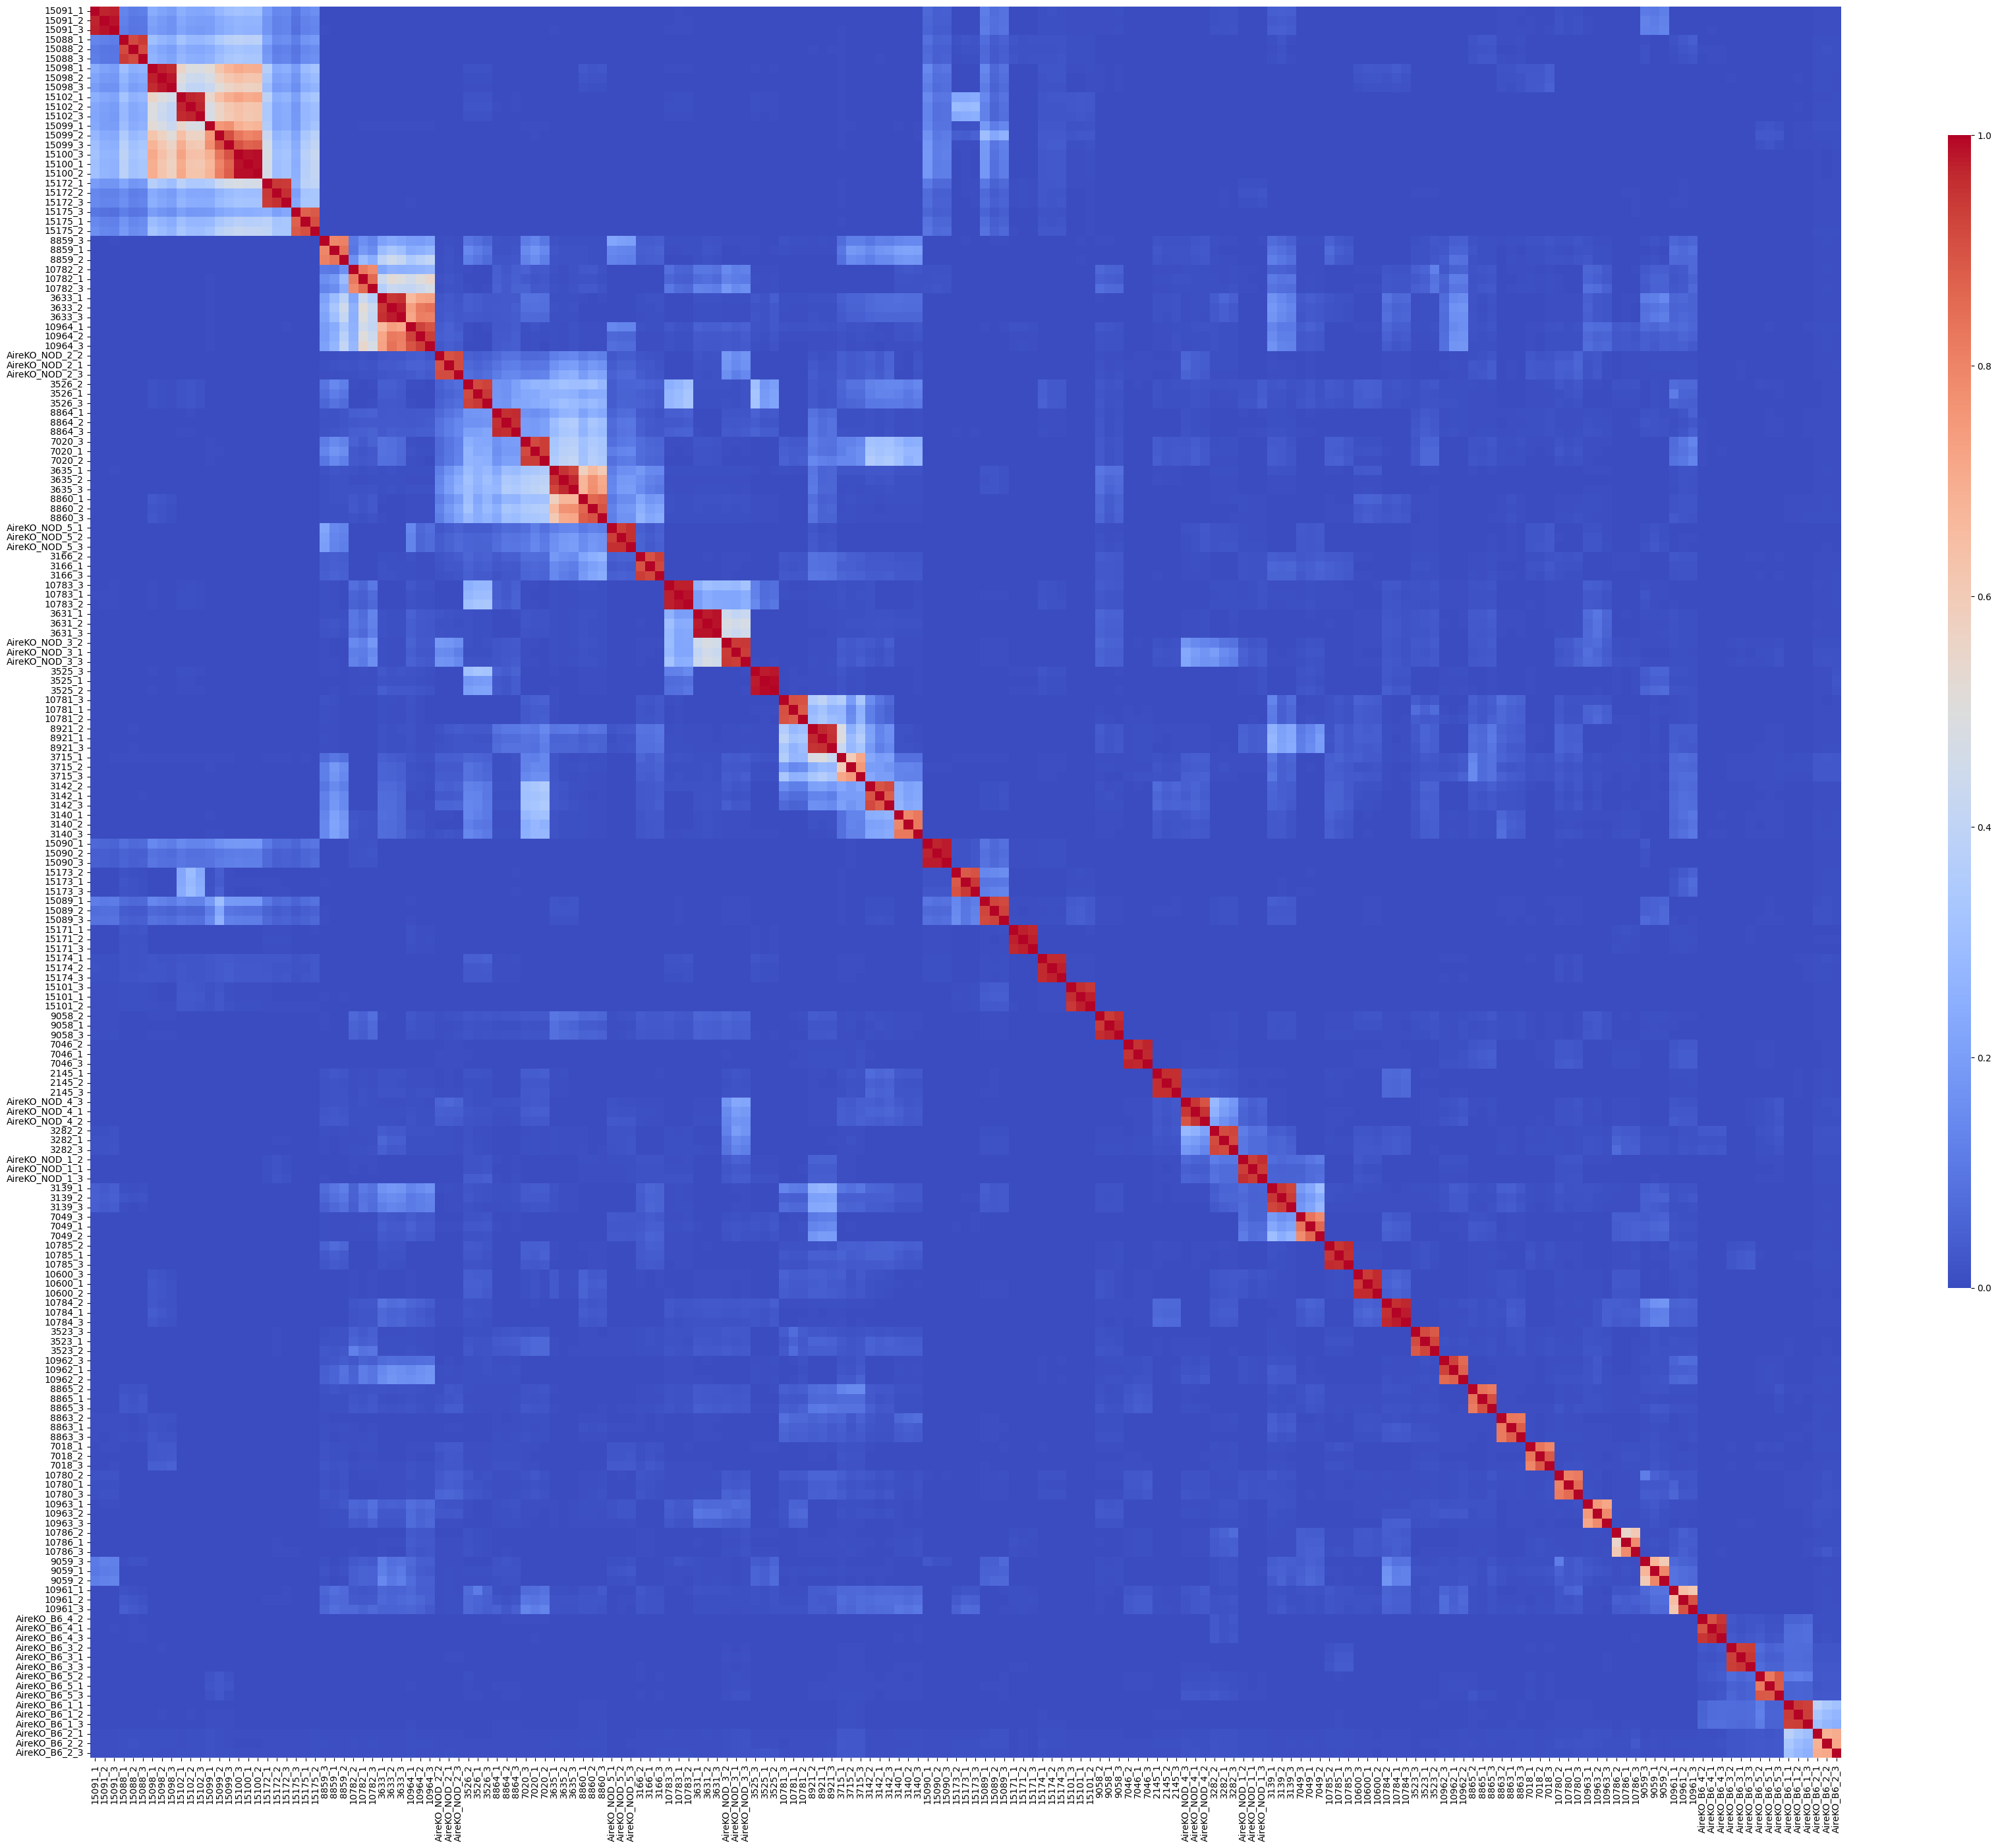

In [54]:
corr_plot(adata[~adata.obs.Genotype.isin(["MockIP", "PosIP", "Rag2KO"])], figsize=(35,35), layer="X", labels="Replicate")

In [55]:
#Take average counts of technical replicates
averaged_adata = average_tech_reps(
    adata = adata,
    sample_key = "Sample_Name"
)

In [56]:
#This file is publically available and can be accessed through https://www.protocols.io/workspaces/derisi-lab
new_annot = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/gene_annotations.csv", index_col=0)
averaged_adata.var["gene"] = new_annot.gene
averaged_adata.var["sequence"] = new_annot.sequence
averaged_adata.obs["neg_control"] = ["Background" if i in ["MockIP", "Rag2KO"] else i for i in averaged_adata.obs.Genotype]

In [57]:
averaged_adata.layers["rpk+1"] = averaged_adata.X + 1

In [58]:
calculate_FC(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='rpk+1',
    layer_added="FC_background"
)
averaged_adata.layers["LFC_background"] = np.log2(averaged_adata.layers["FC_background"])

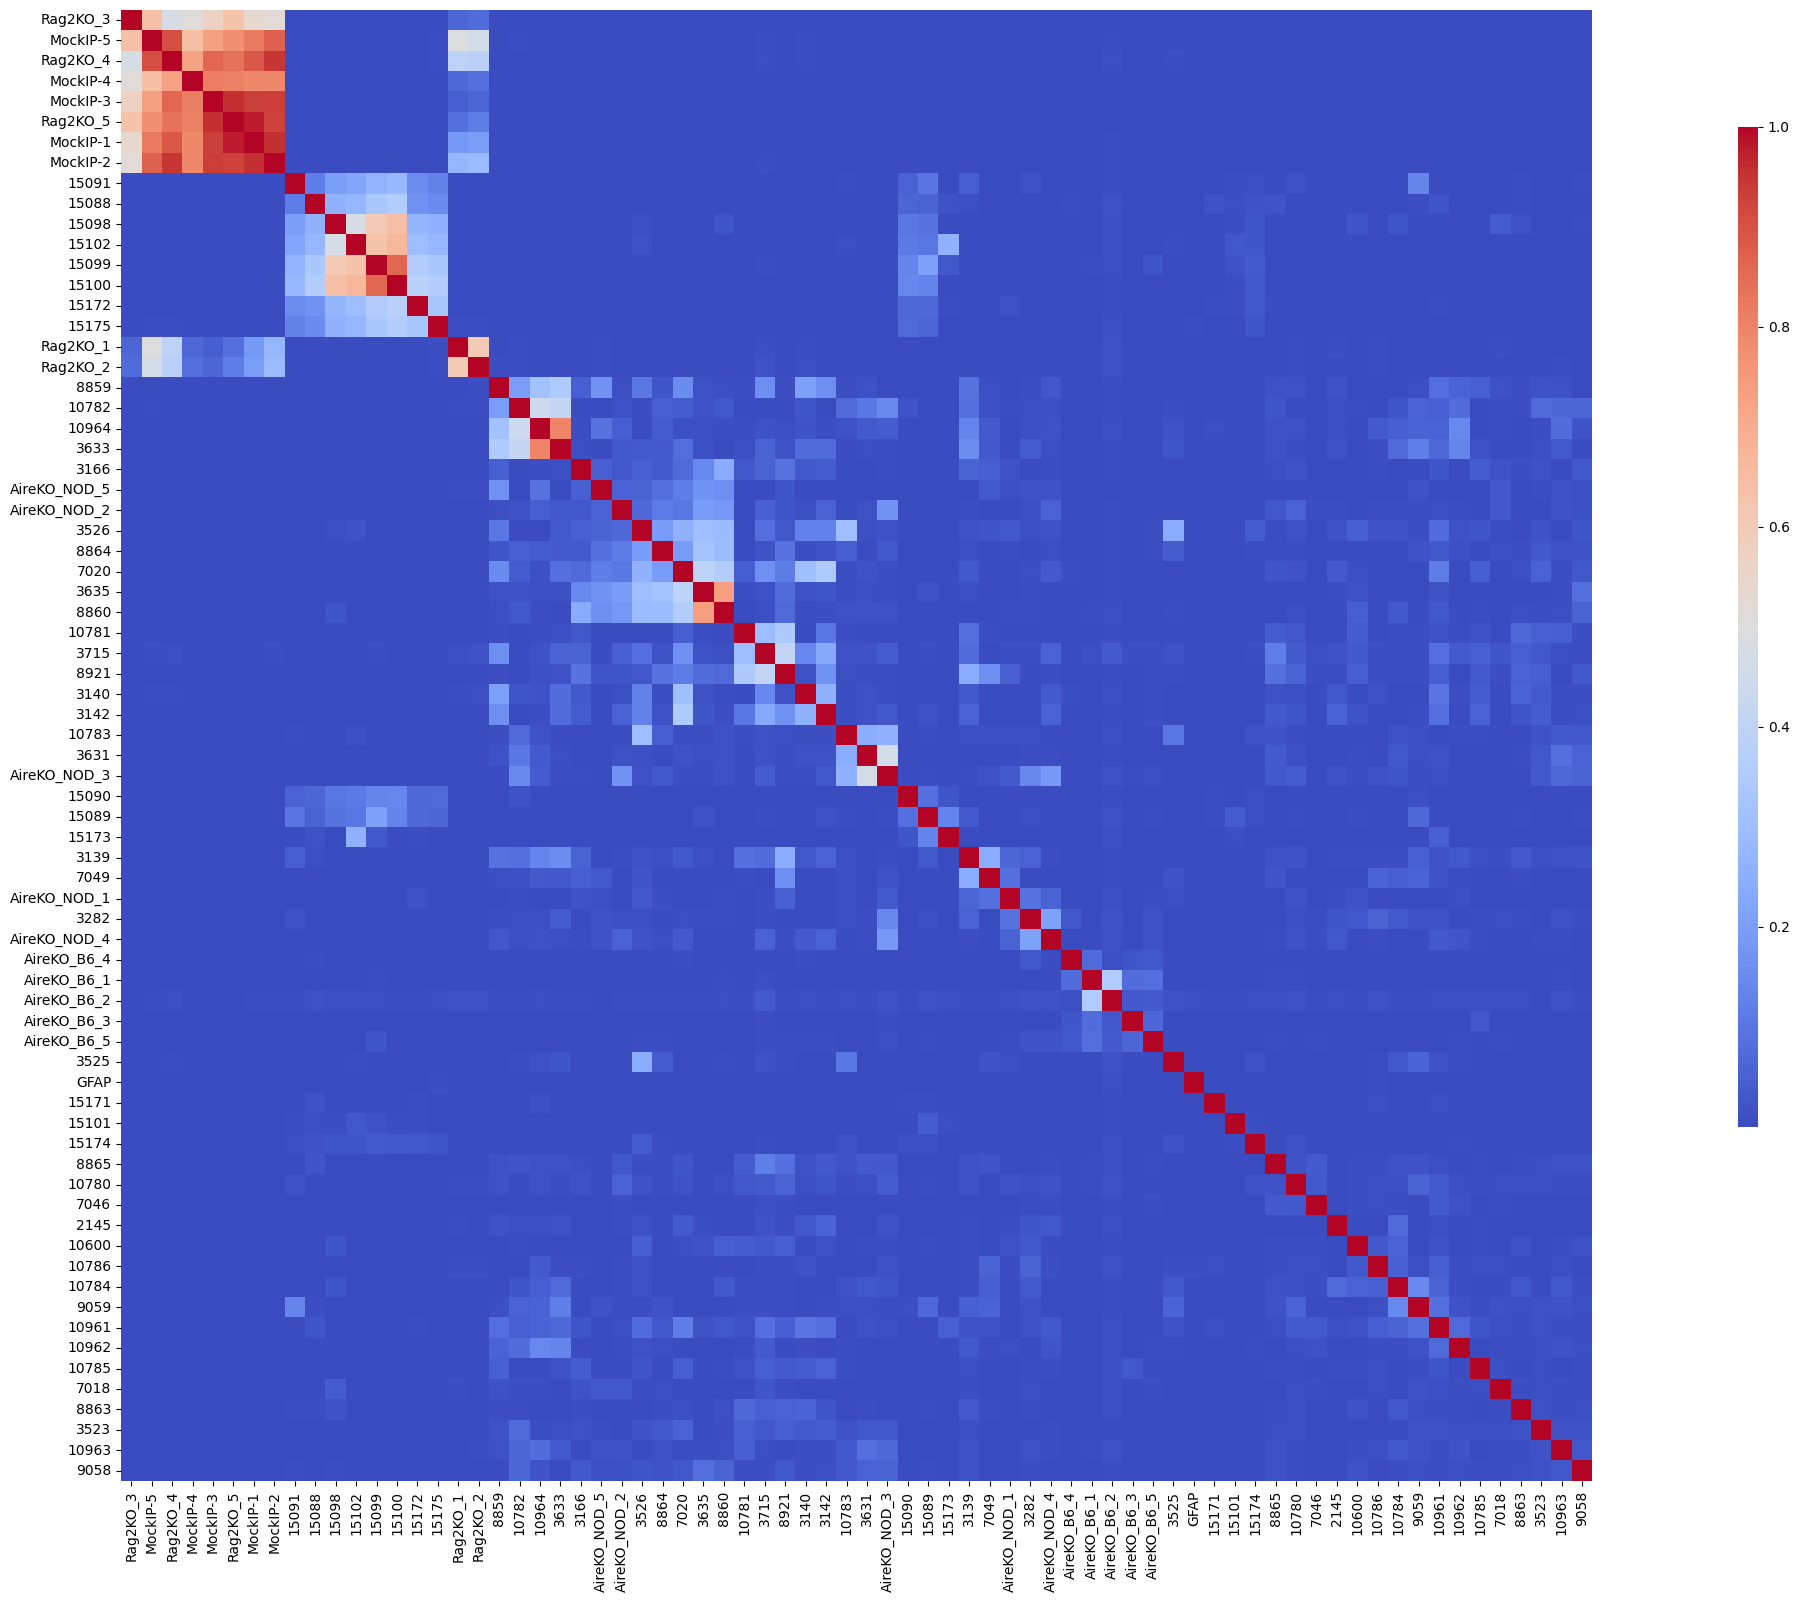

In [59]:
corr_plot(averaged_adata, layer="X", figsize=(20,20), labels="Mouse")

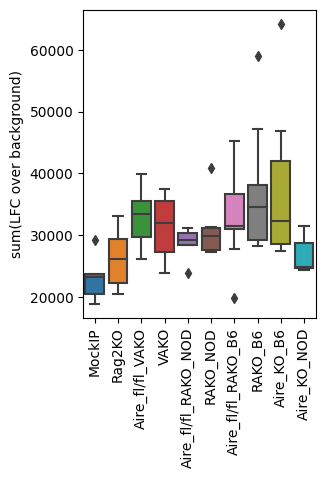

In [60]:
plot_FC_sum(
    averaged_adata,
    "LFC_background",
    "Genotype",
    ["MockIP", "Rag2KO", "Aire_fl/fl_VAKO", "VAKO", "Aire_fl/fl_RAKO_NOD", "RAKO_NOD", "Aire_fl/fl_RAKO_B6", "RAKO_B6", "Aire_KO_B6", "Aire_KO_NOD"],
    order=["MockIP", "Rag2KO", "Aire_fl/fl_VAKO", "VAKO", "Aire_fl/fl_RAKO_NOD", "RAKO_NOD", "Aire_fl/fl_RAKO_B6", "RAKO_B6", "Aire_KO_B6", "Aire_KO_NOD"]
)

In [61]:
calculate_Z(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='LFC_background',
    layer_added="Z_score_background"
)
averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])

/tmp/ipykernel_4178940/824801542.py:8: RuntimeWarning: invalid value encountered in log2
  averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])


In [62]:
get_peptide_stats(
    averaged_adata,
    FC_layer = "LFC_background",
    FC_thresh = np.log2(1.75),
    Z_layer = "Z_score_background",
    Z_thresh = 3,
    obs_grouping_key="neg_control"
)

In [151]:
filtered_hits = averaged_adata.varm['hits'].copy()
filtered_hits = filtered_hits[filtered_hits["Aire_KO_B6_median"] >= np.log2(2)]
filtered_hits = filtered_hits[filtered_hits["Aire_fl/fl_RAKO_B6_median"] <= np.log2(2)]
filtered_hits = filtered_hits[filtered_hits["Aire_fl/fl_VAKO_median"] <= np.log2(2)]
filtered_hits = filtered_hits[filtered_hits.Background_median <= np.log2(2)]

In [152]:
filtered_hits

neg_control,Aire_KO_B6,Aire_KO_NOD,Aire_fl/fl_RAKO_B6,Aire_fl/fl_RAKO_NOD,Aire_fl/fl_VAKO,Background,PosIP,RAKO_B6,RAKO_NOD,VAKO,...,Aire_KO_B6_mean,Aire_KO_NOD_mean,Aire_fl/fl_RAKO_B6_mean,Aire_fl/fl_RAKO_NOD_mean,Aire_fl/fl_VAKO_mean,Background_mean,PosIP_mean,RAKO_B6_mean,RAKO_NOD_mean,VAKO_mean
peptide,,,,,,,,,,,,,,,,,,,,,
NP_808509.1_coiled-coil_domain-containing_protein_187_[Mus_musculus]_seq13,3,0,2,1,0,0,0,0,2,1,...,0.990847,0.383529,0.479776,0.660117,0.413690,0.152201,0.907705,0.467050,1.352072,0.933312
NP_783571.2_perilipin-1_[Mus_musculus]_seq2,3,0,0,0,0,0,0,0,1,0,...,2.923265,0.008630,0.136757,0.000000,0.229938,0.117327,0.408516,0.061614,0.521017,0.260392
NP_783571.2_perilipin-1_[Mus_musculus]_seq3,4,0,0,1,0,0,0,0,0,1,...,5.104874,0.044144,0.132985,0.182101,0.252550,0.065526,0.116787,0.175105,0.202994,0.430763
XP_006506431.1_PREDICTED:_mucin-21_isoform_X2_[Mus_musculus]_seq6,2,0,0,4,0,0,0,0,2,0,...,1.078325,0.016207,0.009957,1.207140,0.051394,0.112429,0.840926,0.000712,1.433119,0.003005
XP_017171873.1_PREDICTED:_regulating_synaptic_membrane_exocytosis_protein_2_isoform_X19_[Mus_musculus]_seq28,2,0,2,0,2,0,0,1,2,0,...,1.108966,0.407843,0.615430,0.600851,0.605397,0.116287,0.624052,0.724098,0.869928,0.380254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_062713.2_forkhead_box_protein_O1_[Mus_musculus]_seq8,4,0,1,1,0,0,0,0,1,0,...,1.369459,0.207056,0.250043,0.201600,0.174387,0.087955,0.075479,0.083692,0.477638,0.145843
XP_006523286.1_PREDICTED:_AT-rich_interactive_domain-containing_protein_1B_isoform_X2_[Mus_musculus]_seq21,4,0,2,0,1,0,0,4,0,0,...,2.600101,0.070638,0.436582,0.117228,0.338371,0.039889,0.490450,0.758541,0.126308,0.075234
NP_035966.2_laminin_subunit_gamma-3_precursor_[Mus_musculus]_seq18,4,0,0,0,0,0,1,0,0,0,...,2.848266,0.085368,0.040533,0.030360,0.035543,0.102653,1.194793,0.094078,0.095816,0.000000


In [154]:
filtered_hits.sort_values(by="Aire_KO_B6_median", ascending=False).head(15).gene

peptide
NP_783571.2_perilipin-1_[Mus_musculus]_seq3                                                                           Plin1
NP_033331.2_synaptophysin_[Mus_musculus]_seq7                                                                           Syp
XP_006536280.1_PREDICTED:_cell_cycle_exit_and_neuronal_differentiation_protein_1_isoform_X1_[Mus_musculus]_seq2       Cend1
NP_659149.1_sodium/potassium-transporting_ATPase_subunit_alpha-1_precursor_[Mus_musculus]_seq1                       Atp1a1
NP_035966.2_laminin_subunit_gamma-3_precursor_[Mus_musculus]_seq18                                                    Lamc3
NP_001074280.1_Splunc6_precursor_[Mus_musculus]_seq2                                                                 Bpifa6
XP_011242133.1_PREDICTED:_myelin_transcription_factor_1-like_protein_isoform_X4_[Mus_musculus]_seq18                  Myt1l
NP_001096649.1_bromodomain_and_WD_repeat-containing_protein_1_isoform_B_[Mus_musculus]_seq52                          Brwd1


In [161]:
filtered_hits[filtered_hits.gene == "Myt1l"]

neg_control,Aire_KO_B6,Aire_KO_NOD,Aire_fl/fl_RAKO_B6,Aire_fl/fl_RAKO_NOD,Aire_fl/fl_VAKO,Background,PosIP,RAKO_B6,RAKO_NOD,VAKO,...,Aire_KO_B6_mean,Aire_KO_NOD_mean,Aire_fl/fl_RAKO_B6_mean,Aire_fl/fl_RAKO_NOD_mean,Aire_fl/fl_VAKO_mean,Background_mean,PosIP_mean,RAKO_B6_mean,RAKO_NOD_mean,VAKO_mean
peptide,,,,,,,,,,,,,,,,,,,,,
XP_011242137.1_PREDICTED:_myelin_transcription_factor_1-like_protein_isoform_X11_[Mus_musculus]_seq17,5,0,1,0,3,0,0,1,0,1,...,2.338685,0.206830,0.308799,0.211979,0.695518,0.128698,0.108975,0.421109,0.153975,0.394489
XP_011242137.1_PREDICTED:_myelin_transcription_factor_1-like_protein_isoform_X11_[Mus_musculus]_seq18,4,1,1,0,2,0,0,2,1,0,...,2.284368,0.515985,0.312710,0.232343,0.563539,0.124658,0.583771,0.481052,0.447000,0.398082
XP_011242124.1_PREDICTED:_myelin_transcription_factor_1-like_protein_isoform_X1_[Mus_musculus]_seq19,5,0,0,0,0,0,0,0,1,0,...,1.815851,0.027179,0.032906,0.012512,0.167154,0.079992,0.000000,0.215296,0.614388,0.007098
XP_011242133.1_PREDICTED:_myelin_transcription_factor_1-like_protein_isoform_X4_[Mus_musculus]_seq18,5,1,0,0,0,0,0,2,1,0,...,2.928877,0.643878,0.182614,0.269029,0.036158,0.132319,0.303871,0.680868,0.218102,0.221271


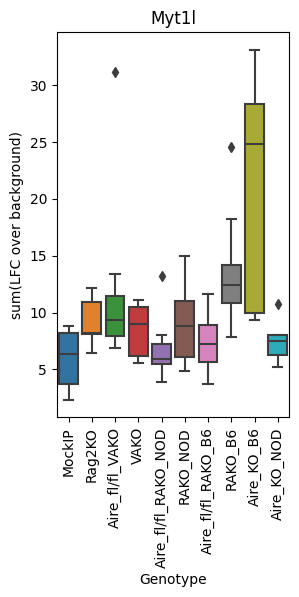

In [162]:
gene_LFC_sum_plot(
    averaged_adata,
    gene="Myt1l",
    LFC_layer="LFC_background",
    obs_grouping_key="Genotype",
    include_groups=["MockIP", "Rag2KO", "Aire_fl/fl_VAKO", "VAKO", "Aire_fl/fl_RAKO_NOD", "RAKO_NOD", "Aire_fl/fl_RAKO_B6", "RAKO_B6", "Aire_KO_B6", "Aire_KO_NOD"],
    order=["MockIP", "Rag2KO", "Aire_fl/fl_VAKO", "VAKO", "Aire_fl/fl_RAKO_NOD", "RAKO_NOD", "Aire_fl/fl_RAKO_B6", "RAKO_B6", "Aire_KO_B6", "Aire_KO_NOD"]
)

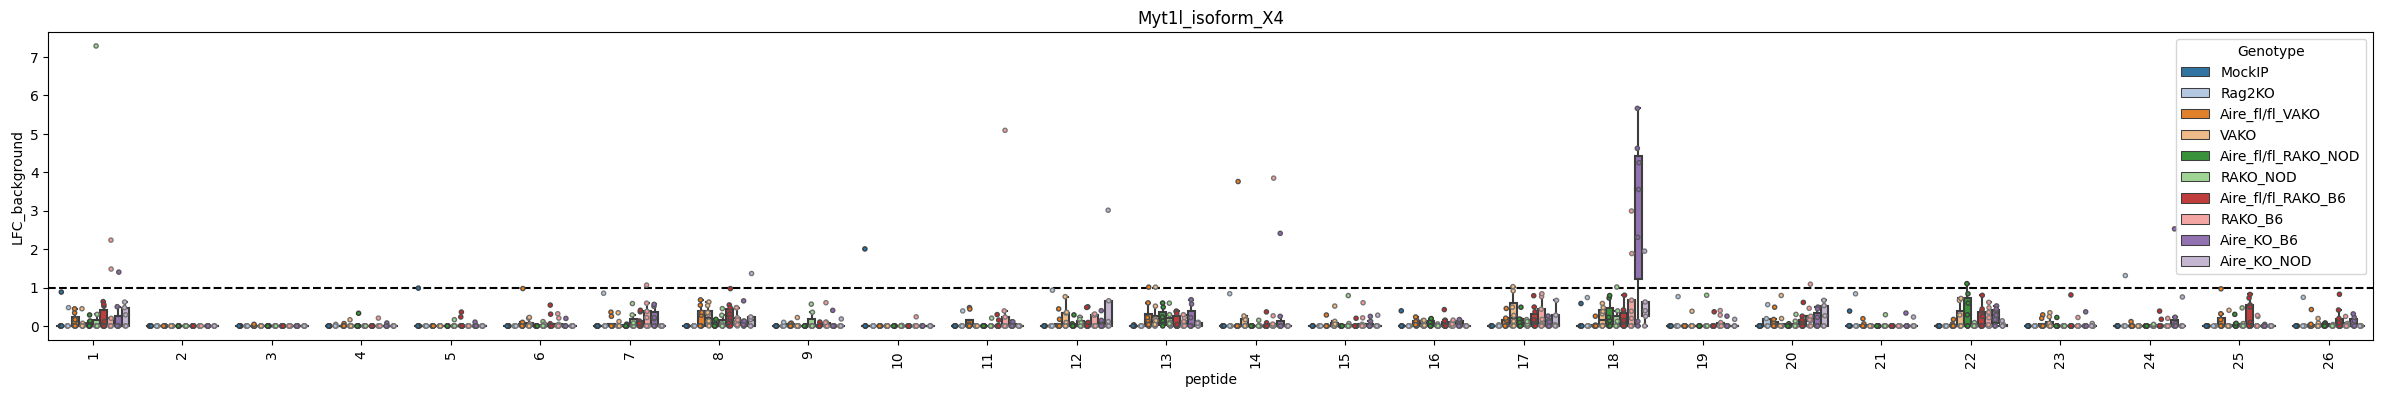

In [165]:
gene_level_box_plot(
    averaged_adata,
    "Genotype",
    layer="LFC_background",
    gene="Myt1l",
    isoform_subset = "isoform_X4",
    threshold=np.log2(2),
    figsize=(30,4),
    palette="tab20",
    hue_order=["MockIP", "Rag2KO", "Aire_fl/fl_VAKO", "VAKO", "Aire_fl/fl_RAKO_NOD", "RAKO_NOD", "Aire_fl/fl_RAKO_B6", "RAKO_B6", "Aire_KO_B6", "Aire_KO_NOD"]
)

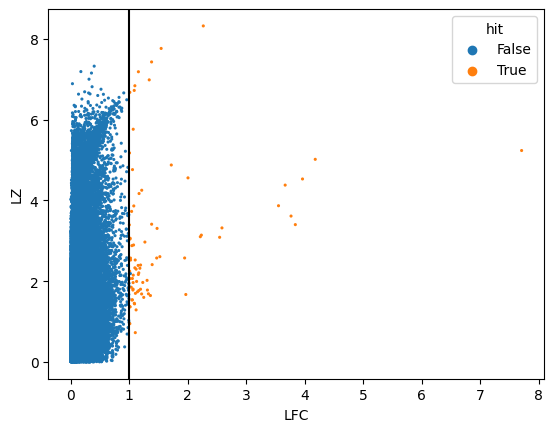

In [168]:
median_LFC_Z_score_plot(
    averaged_adata,
    Z_layer="LZ_score_background",
    LFC_layer="LFC_background",
    obs_grouping_key="Genotype",
    obs_grouping_subset="Aire_KO_B6",
    hits=filtered_hits.index,
    LFC_thresh=2
)